In [1]:
# Synthetic Data Course on LearnCrunch: Preliminary Exercise
# Dustin Chambers
# January 29, 2023

# interpol_fourier.py (author: MLTechniques.com)
import numpy as np
import mpmath
import matplotlib as mpl
from matplotlib import pyplot as plt

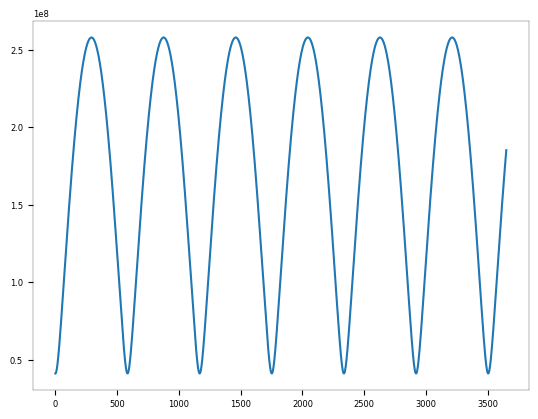

In [118]:
# Step 1 - Use Formula (1) to generate daily values of Distance between Earth and Venus

# Distance between Earth and Venus at time (t)
THETA_V = 224.7
THETA_E = 365.2
R_V = 108.2e6
R_E = 149.6e6
OMEGA_V = float((2*np.pi)/THETA_V)
OMEGA_E = float((2*np.pi)/THETA_E)

def d_V(t):
    d_V_sq = (R_E**2)*(1 + ((R_V/R_E)**2) - 2*(R_V/R_E)*np.cos((OMEGA_V-OMEGA_E)*t))
    return d_V_sq**(0.5)
    
# Generate 10 years of daily distance data
t_start = 0
t_end = 3652

plot_values = []

temp = {}
# t/t_unit is an integer every t_unit observations (node)
t_unit = 32 # for planet data discussed in the classroom  

for t in range(t_end):
    evDistance = float(d_V(t))
    temp[t/t_unit] = evDistance
    plot_values.append(evDistance)


nobs = len(temp)

plt.plot(plot_values)

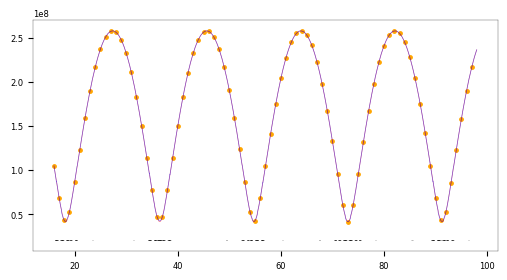

In [119]:
# Step 2 - Venus and Earth Distance Interpolation

mode = 'Data' # options: 'Data', 'Math.Bessel', 'Math.Zeta'

def g(t):
    if mode == 'Data':
        z = temp[t]
    elif mode == 'Math.Bessel':
        t = 40*(t-t_min)/(t_max-t_min) 
        z = mpmath.besselj(1,t) 
        z = float(z.real) # real part of the complex-valued function
    elif mode == 'Math.Zeta': 
        t = 4 + 40*(t-t_min)/(t_max-t_min) 
        z = mpmath.zeta(complex(0.5,t)) 
        z = float(z.real) # real part of the complex-valued function
    return(z)

#--- interpolation function

def interpolate(t, eps): 
    sum = 0
    t_0 = int(t + 0.5) # closest interpolation node to t
    pi2 = 2/np.pi  
    flag1 = -1  
    flag2 = -1  
    for k in range(0, n):
        # use nodes k1, k2 in interpolation formula
        k1 = t_0 + k
        k2 = t_0 - k
        tt = t - t_0
        if k != 0: 
            if k %2 == 0:
                z = g(k1) + g(k2) 
                if abs(tt**2 - k**2) > eps:
                    term = flag1 * tt*z*pi2 * np.sin(tt/pi2) / (tt**2 - k**2)
                else:    
                    # use limit as tt --> k
                    term = z/2
                flag1 = -flag1
            else: 
                z = g(k1) - g(k2) 
                if abs(tt**2 - k**2) > eps:
                    term = flag2 * tt*z*pi2 * np.cos(tt/pi2) / (tt**2 - k**2)
                else: 
                    # use limit as tt --> k
                    term = z/2
                flag2 = -flag2
        else: 
            z = g(k1)
            if abs(tt) > eps:
                term = z*pi2*np.sin(tt/pi2) / tt
            else:
                # use limit as tt --> k (here k = 0)
                term = z
        sum += term
    return(sum)

#--- main loop and visualizations 

n  = 16   
    # 2n+1 is number of nodes used in interpolation 
    # in all 3 cases tested (data, math functions), n >= 8 works 
if mode=='Data':
    # restrictions: 
    #     t_min >= n, t_max  <= int(nobs/t_unit - n)
    #     t_max > t_min, at least one node between t_min and t_max
    t_min  = n  # interpolate between t_min and t_max 
    t_max  = int(nobs/t_unit - n)  # must have t_max - t_min > 0
else:
    t_min = 0
    t_max = 100
incr   = 1/t_unit   # time increment between nodes 
eps    = 1.0e-12 

OUT = open("interpol_planets_earth_venus.txt","w")

time = []
ze = []
zi = []

fig = plt.figure(figsize=(6,3))
mpl.rcParams['axes.linewidth'] = 0.2
mpl.rc('xtick', labelsize=6) 
mpl.rc('ytick', labelsize=6) 

for t in np.arange(t_min, t_max, incr):  
    time.append(t)
    z_interpol = interpolate(t, eps) 
    z_exact = g(t)
    zi.append(z_interpol)
    ze.append(z_exact)
    error = abs(z_exact - z_interpol)
    if t == int(t):
        plt.scatter(t,z_exact,color='orange', s=6)
    #print("t = %8.5f exact = %8.5f interpolated = %8.5f error = %8.5f %3d nodes" % (t,z_exact,z_interpol,error,n))
    OUT.write("%10.6f\t%10.6f\t%10.6f\t%10.6f\n" % (t,z_exact,z_interpol,error))
OUT.close()

plt.plot(time,ze,color='red',linewidth = 0.5, alpha=0.5) 
plt.plot(time,zi,color='blue', linewidth = 0.5,alpha=0.5)
base = min(ze) - (max(ze) -min(ze))/10
for index in range(len(time)):
    # plot error bars showing delta between exact and interpolated values
    t = time[index]
    error = abs(zi[index]-ze[index])
    plt.vlines(t,base,base+error,color='black',linewidth=0.2) 
plt.savefig('planets_earth_venus.png', dpi=200)
plt.show()

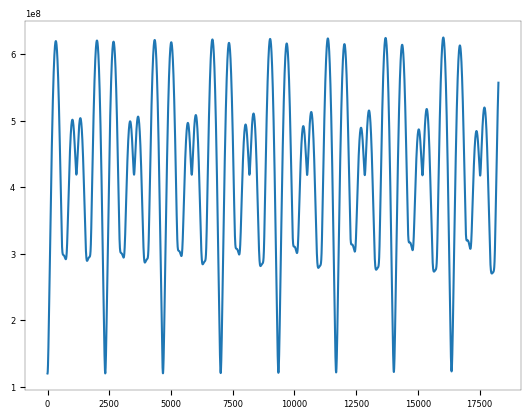

In [120]:
# Step 3A - Add Mars - Generate DGP Data (g(t))

# Distance between Mars and Earth at time (t)
THETA_M = 687.0
R_M = 228.0e6
OMEGA_M = float((2*np.pi)/THETA_M)

def d_M(t):
    d_M_sq = (R_M**2)*(1 + ((R_E/R_M)**2) - 2*(R_E/R_M)*np.cos((OMEGA_E-OMEGA_M)*t))
    return d_M_sq**(0.5)

# Distance between Mars and Earth plus Earth to Venus at time (t)
def d_MEV(t):
    combinedDistance = d_V(t) + d_M(t)
    return combinedDistance

# Generate 50 years of daily distance data
years = 50;
t_start = 0
t_end = int(THETA_E*years)

plot_values = []

temp = {}
# t/t_unit is an integer every t_unit observations (node)
t_unit = 32 # for planet data discussed in the classroom  

for t in range(t_end):
    mevDistance = float(d_MEV(t))
    temp[t/t_unit] = mevDistance
    plot_values.append(mevDistance)


nobs = len(temp)

plt.plot(plot_values)






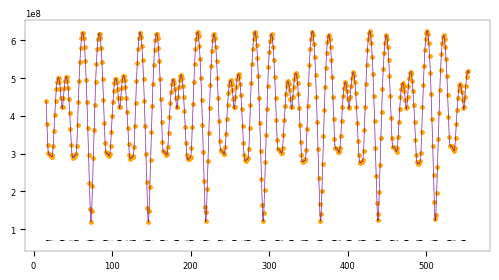

In [121]:
# Step 3B - Add Mars - Interpolation Exercise

#--- main loop and visualizations 

n  = 16   
    # 2n+1 is number of nodes used in interpolation 
    # in all 3 cases tested (data, math functions), n >= 8 works 
if mode=='Data':
    # restrictions: 
    #     t_min >= n, t_max  <= int(nobs/t_unit - n)
    #     t_max > t_min, at least one node between t_min and t_max
    t_min  = n  # interpolate between t_min and t_max 
    t_max  = int(nobs/t_unit - n)  # must have t_max - t_min > 0
else:
    t_min = 0
    t_max = 100
incr   = 1/t_unit   # time increment between nodes 
eps    = 1.0e-12 

OUT = open("interpol_planets_mars_earth_venus.txt","w")

time = []
ze = []
zi = []

fig = plt.figure(figsize=(6,3))
mpl.rcParams['axes.linewidth'] = 0.2
mpl.rc('xtick', labelsize=6) 
mpl.rc('ytick', labelsize=6) 

for t in np.arange(t_min, t_max, incr):  
    time.append(t)
    z_interpol = interpolate(t, eps) 
    z_exact = g(t)
    zi.append(z_interpol)
    ze.append(z_exact)
    error = abs(z_exact - z_interpol)
    if t == int(t):
        plt.scatter(t,z_exact,color='orange', s=6)
    #print("t = %8.5f exact = %8.5f interpolated = %8.5f error = %8.5f %3d nodes" % (t,z_exact,z_interpol,error,n))
    OUT.write("%10.6f\t%10.6f\t%10.6f\t%10.6f\n" % (t,z_exact,z_interpol,error))
OUT.close()

plt.plot(time,ze,color='red',linewidth = 0.5, alpha=0.5) 
plt.plot(time,zi,color='blue', linewidth = 0.5,alpha=0.5)
base = min(ze) - (max(ze) -min(ze))/10
for index in range(len(time)):
    # plot error bars showing delta between exact and interpolated values
    t = time[index]
    error = abs(zi[index]-ze[index])
    plt.vlines(t,base,base+error,color='black',linewidth=0.2) 
plt.savefig('planets_mars_earth_venus.png', dpi=200)
plt.show()

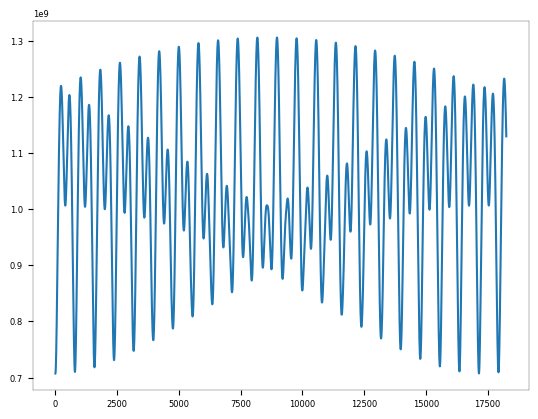

In [122]:
# Step 4 - Replace Venus with Jupiter and Repeat Steps 1 and 2

# Distance between Jupiter and Earth at time (t)

THETA_J = 4331
R_J = 778.5e6
OMEGA_J = float((2*np.pi)/THETA_J)

def d_J(t):
    d_J_sq = (R_J**2)*(1 + ((R_E/R_J)**2) - 2*(R_E/R_J)*np.cos((OMEGA_E-OMEGA_J)*t))
    return d_J_sq**(0.5)

# Distance between Jupiter, Mars, and Earth (pairwise, straight lines)
def d_JME(t):
    combinedDistance = d_M(t) + d_J(t)
    return combinedDistance

# Generate 50 years of daily distance data
years = 50;
t_start = 0
t_end = int(THETA_E*years)

plot_values = []

temp = {}
# t/t_unit is an integer every t_unit observations (node)
t_unit = 32 # for planet data discussed in the classroom  

for t in range(t_end):
    jmeDistance = float(d_JME(t))
    temp[t/t_unit] = jmeDistance
    plot_values.append(jmeDistance)


nobs = len(temp)

plt.plot(plot_values)


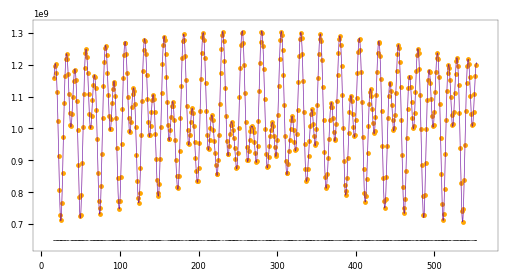

In [123]:
# Step 4B - Replace Venus with Jupiter and Repeat Steps 1 and 2

n  = 16   
    # 2n+1 is number of nodes used in interpolation 
    # in all 3 cases tested (data, math functions), n >= 8 works 
if mode=='Data':
    # restrictions: 
    #     t_min >= n, t_max  <= int(nobs/t_unit - n)
    #     t_max > t_min, at least one node between t_min and t_max
    t_min  = n  # interpolate between t_min and t_max 
    t_max  = int(nobs/t_unit - n)  # must have t_max - t_min > 0
else:
    t_min = 0
    t_max = 100
incr   = 1/t_unit   # time increment between nodes 
eps    = 1.0e-12 

OUT = open("interpol_planets_jupiter_mars_earth.txt","w")

time = []
ze = []
zi = []

fig = plt.figure(figsize=(6,3))
mpl.rcParams['axes.linewidth'] = 0.2
mpl.rc('xtick', labelsize=6) 
mpl.rc('ytick', labelsize=6) 

for t in np.arange(t_min, t_max, incr):  
    time.append(t)
    z_interpol = interpolate(t, eps) 
    z_exact = g(t)
    zi.append(z_interpol)
    ze.append(z_exact)
    error = abs(z_exact - z_interpol)
    if t == int(t):
        plt.scatter(t,z_exact,color='orange', s=6)
    #print("t = %8.5f exact = %8.5f interpolated = %8.5f error = %8.5f %3d nodes" % (t,z_exact,z_interpol,error,n))
    OUT.write("%10.6f\t%10.6f\t%10.6f\t%10.6f\n" % (t,z_exact,z_interpol,error))
OUT.close()

plt.plot(time,ze,color='red',linewidth = 0.5, alpha=0.5) 
plt.plot(time,zi,color='blue', linewidth = 0.5,alpha=0.5)
base = min(ze) - (max(ze) -min(ze))/10
for index in range(len(time)):
    # plot error bars showing delta between exact and interpolated values
    t = time[index]
    error = abs(zi[index]-ze[index])
    plt.vlines(t,base,base+error,color='black',linewidth=0.2) 
plt.savefig('planets_jupiter_mars_earth.png', dpi=200)
plt.show()

In [124]:
# Step 5 - General Time Series Formula

import statistics

# Normalize Time Series (mu = 0; sigma = 1)
def normalizeTimeSeries (timeSeries):
    tsMean = statistics.mean(timeSeries)
    tsSigma = statistics.pstdev(timeSeries)
    timeSeries[:] = [number - tsMean for number in timeSeries]
    timeSeries[:] = [number/tsSigma for number in timeSeries]


# Generate Time Series Data
# phi = 0

def generateTimeSeries (m,scaleParameter,capT) -> tuple[list,list]:
    
    timeSeries = []
    A = np.random.rand(m)
    A[:] = [scaleParameter*number for number in A]
    APrime = np.random.rand(m)
    APrime[:] = [scaleParameter*number for number in APrime]
    omega = np.random.rand(m)
    omega[:] = [scaleParameter*number for number in omega]
    omegaPrime = np.random.rand(m)
    omegaPrime[:] = [scaleParameter*number for number in omegaPrime]
    tempParameters = [A,APrime,omega,omegaPrime]
    
    for t in range(capT):
        ft = 0
        for k in range(m):
            tempSum = A[k]*np.sin(omega[k]*t) + APrime[k]*np.cos(omegaPrime[k]*t)
            ft += tempSum
        timeSeries.append(ft)
    
    normalizeTimeSeries(timeSeries)
    return timeSeries, tempParameters



0.06603122491902863
0.12096778197861639
0.2756195461740702
0.39368622669745695
0.4266509615949584
0.4739217473296897
0.5549546773696798
0.636379566762911
0.6414795475627556
0.6539832541966519
0.6694121576796168
[array([0.00018535, 0.00655214]), array([0.0033217 , 0.00221089]), array([0.01920457, 0.01015945]), array([0.0122879 , 0.00628489])]


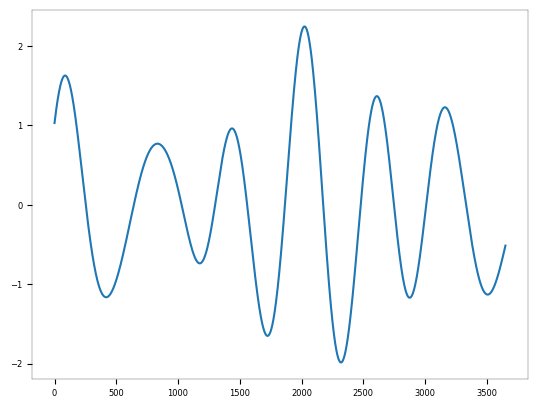

In [127]:
# Step 6 - One Million Monte Carlo Simulations vs Earth-Venus Distance data

# Generate 10 years of daily distance data
t_start = 0
t_end = 3652

earth_venus_values = []

# t/t_unit is an integer every t_unit observations (node)
t_unit = 32 # for planet data discussed in the classroom  

for t in range(t_end):
    evDistance = float(d_V(t))
    temp[t/t_unit] = evDistance
    earth_venus_values.append(evDistance)

nobs = len(earth_venus_values)

# Normalize Planetary Distance Measures
normalizeTimeSeries(earth_venus_values)

# Outside Jupyter-Notebook, a multiprocessing pool to compute this in parallel would be much faster
# totalSimulations = int(1.0e6)
totalSimulations = 10000 # A million simulations was too slow on my laptop; I ran 10k instead
peakCrossCorrelation = []
m = 2
# I limited the width of the uniform sampling distribution to speed-up convergence to reasonable parameter estimates
scaleParameter = 0.02 
maxCorr = 0
maxParameters = []
bestTS = []

for i in range(totalSimulations):
    results = generateTimeSeries(m,scaleParameter,t_end)
    randTS = results[0]
    # I used a simple cross-correlation (and selected the highest value based on lag (l))
    # Since both series are normalized, the cross-correlation of the target series on itself would equal: 
    # N*E(d(t)^2) = NVar(d) = N (since time series is normalized).  Therefore, I normalized the cross-correlation values by N to bound the measure
    # between -1 and 1
    crossCorr = np.correlate(earth_venus_values, randTS)
    crossCorr.sort()
    tempCorr = crossCorr[-1]/nobs
    peakCrossCorrelation.append(tempCorr)
    if tempCorr > maxCorr:
        maxCorr = tempCorr
        maxParameters = results[1]
        print(tempCorr)
        bestTS = randTS

print(maxParameters)
# plt.hist(peakCrossCorrelation)
plt.plot(bestTS)

0.04833732206296964
0.10809457795676501
0.3565740265302007
0.4958093445472271
0.7027824821143047
0.7039408657853665
0.7063650150415051
[array([0.00644718]), array([7.32092403e-05]), array([0.01012839]), array([0.01302004])]


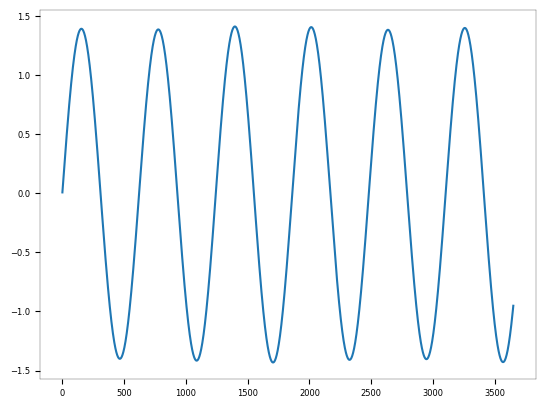

In [128]:
# Step 7 - One Million Monte Carlo Simulations vs Earth-Venus Distance data

# 4 Parameter Model (m = 1)

# Outside Jupyter-Notebook, a multiprocessing pool to compute this in parallel would be much faster
# totalSimulations = int(1.0e6)
totalSimulations = 10000 # A million simulations was too slow on my laptop; I ran 10k instead
peakCrossCorrelation = []
m = 1
scaleParameter = 0.025
maxCorr = 0
maxParameters = []
bestTS = []

for i in range(totalSimulations):
    results = generateTimeSeries(m,scaleParameter,t_end)
    randTS = results[0]
    crossCorr = np.correlate(earth_venus_values, randTS)
    crossCorr.sort()
    tempCorr = crossCorr[-1]/nobs
    peakCrossCorrelation.append(tempCorr)
    if tempCorr > maxCorr:
        maxCorr = tempCorr
        maxParameters = results[1]
        print(tempCorr)
        bestTS = randTS
    
print(maxParameters)
# plt.hist(peakCrossCorrelation)
plt.plot(bestTS)